# Predicting fertility rates 
This project will use machine learning to predict fertility rates based on several factors. This data is taken via Google Bigquery from a subset of the World Health Organization's public database.

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Import Data
Data contains health metrics from countries around the world in 2010. Region information has been added

In [2]:
data = pd.read_csv('WorldHealthFertilityRates2010.csv', usecols=['country_name','indicator_name','value'])
data.head()

,country_name,indicator_name,value
0,Greenland,"Age at first marriage, female",31.2
1,Belize,"Age at first marriage, female",28.6
2,Bermuda,"Age at first marriage, female",30.6
3,Eswatini,"Age at first marriage, female",26.2
4,Afghanistan,"Age at first marriage, female",21.5


We see the data is in long form, which we'll have to change for some analysis. The indicator names are also long and contain characters such as spaces and commas, which will make things difficult in further analysis. We'll adjust the indicator names.

In [3]:
data = data.replace({'indicator_name':{'Age at first marriage, female':'afm',
                                    'Lifetime risk of maternal death (%)':'lrd',
                                    'Nurses and midwives (per 1,000 people)':'nam',
                                    'Fertility rate, total (births per woman)':'fr',
                                    'Rural population (% of total population)':'rpop',
                                    'Labor force, female (% of total labor force)':'lff',
                                    'Unemployment, total (% of total labor force)':'ue',
                                    'School enrollment, tertiary, female (% gross)':'setf',
                                    'Mortality rate, infant (per 1,000 live births)':'mri',
                                    'Births attended by skilled health staff (% of total)':'bss',
                                    'Contraceptive prevalence, any methods (% of women ages 15-49)': 'con',
                                    'Risk of catastrophic expenditure for surgical care (% of people at risk)':'cex'
                    }})

#check that it was successful. The 'Region' indicator name is short enough we can leave it as it is
print(data.indicator_name.unique())

['afm' 'lrd' 'nam' 'fr' 'rpop' 'lff' 'ue' 'setf' 'mri' 'bss' 'con' 'cex'
 'Region']


Convert to wide form as this will help us further calculations

In [4]:
data = data.pivot(index = 'country_name',columns = 'indicator_name')
data.columns = data.columns.droplevel(0)

Since we interested in fertility rate ('fr'), I'll immediately drop rows where 'fr' == NaN

In [5]:
data.dropna(subset = ['fr'], inplace = True)

## Explore and Clean
Check data type of each variable

In [6]:
data.dtypes

indicator_name
Region    object
afm       object
bss       object
cex       object
con       object
fr        object
lff       object
lrd       object
mri       object
nam       object
rpop      object
setf      object
ue        object
dtype: object

Convert everything except region to numeric

In [7]:
numeric_vars = ['afm', 'lrd', 'nam', 'fr', 'rpop', 'lff', 'ue', 'setf', 'mri', 'bss', 'con', 'cex']
data[numeric_vars] = data[numeric_vars].apply(pd.to_numeric)
data.dtypes

indicator_name
Region     object
afm       float64
bss       float64
cex       float64
con       float64
fr        float64
lff       float64
lrd       float64
mri       float64
nam       float64
rpop      float64
setf      float64
ue        float64
dtype: object

## Convert fertility rate data to 2 categories
In this analysis we want to compare characteristics of countries on the basis of whether the fertility rate is above or below the replacement rate (2.1), so we will re-code the variable 'fr' with 1: fr >= 2.1, 0: < 2.1

In [8]:
data.fr = data.fr = data.fr.apply(lambda x: 'below' if x < 2.1 else 'above')
data.head()

indicator_name,Region,afm,bss,cex,con,fr,lff,lrd,mri,nam,rpop,setf,ue
country_name,,,,,,,,,,,,,
Afghanistan,Asia,21.5,34.3,NaN,21.8,above,15.479167,6.039311,64.1,NaN,76.263,NaN,11.52
Albania,Europe,NaN,NaN,NaN,NaN,below,42.444072,0.033876,11.8,4.0183,47.837,51.571091,14.09
Algeria,Africa,NaN,NaN,16.6,NaN,above,16.882805,0.344174,23.6,1.9470,32.460,35.421070,9.96
Andorra,Europe,NaN,NaN,NaN,NaN,below,NaN,NaN,4.3,4.7650,11.181,NaN,NaN
Angola,Africa,NaN,NaN,27.2,NaN,above,49.850111,2.151459,75.9,NaN,40.217,NaN,9.43


In [9]:
## Summary statistics

In [10]:
data.describe()

indicator_name,afm,bss,cex,con,lff,lrd,mri,nam,rpop,setf,ue
count,77.000000,111.000000,129.000000,49.000000,185.000000,183.000000,183.000000,152.000000,196.000000,123.000000,185.000000
mean,22.932468,71.836486,26.498450,39.614774,40.854418,0.920860,25.775410,4.016938,42.981158,41.466081,8.254054
std,8.424267,38.866181,26.130125,29.397932,9.497626,1.558962,25.032142,3.752545,23.571972,32.562444,5.998852
min,1.000000,1.000000,0.100000,1.000000,11.413122,0.003041,1.000000,0.114000,1.000000,0.535210,0.450000
25%,21.600000,46.400000,1.000000,13.300000,37.768001,0.032675,5.450000,0.869200,23.528250,10.881490,4.030000
50%,24.400000,98.200000,20.200000,46.100000,43.917519,0.164156,16.200000,2.829800,42.997000,37.792278,7.150000
75%,28.500000,99.450000,43.600000,65.600000,47.251744,0.956909,42.100000,5.732825,61.474750,66.681480,10.850000
max,33.200000,99.960000,93.700000,89.100000,54.160085,8.463112,107.200000,16.665900,89.358000,118.624901,32.020000


From the table above we see a lot of variables are missing data. This will have to be taken into account in further analysis.
- Opportunity to use imputation?  
Also a lot of minimums of 1.0. This will have to be checked.

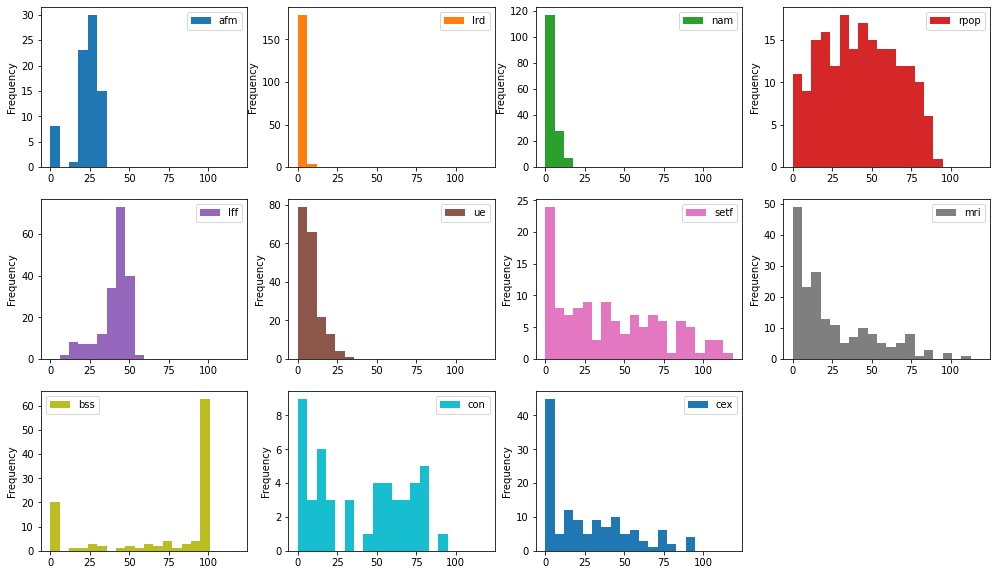

In [11]:
#define columns with independent numeric variables
numeric_ind = ['afm', 'lrd', 'nam', 'rpop', 'lff', 'ue', 'setf', 'mri', 'bss', 'con', 'cex']
data[numeric_ind].plot.hist(subplots = True, layout = (3,4), figsize = (17,10), sharex = False, bins = 20);


Although some variables are displayed well, we can get a rough feeling for the distribution of others. One thing that's noticable is the amount of values around 1. Considering how many minimum values at 1.0 we saw in the summary statistics, it's possible that these peaks are at exactly 1. This makes me wonder if the data is real. For some variables with a peak at 1.0 (Age at first marriage, Births attended by skilled health staff, School enrollment, tertiary, female (% gross), or afm, bss, setf), this seems quite unlikely that the values at 1.0 real. Let's look at the frequency of values at 1.0 per row.

In [12]:
data[numeric_ind][data[numeric_ind] == 1].count()

indicator_name
afm      8
lrd      0
nam      0
rpop     5
lff      0
ue       2
setf     0
mri     11
bss     20
con      8
cex     18
dtype: int64

Although a 1.0 for some of these factors is more plausable than for others, to be safe (and consistent) we'll replace all the 1.0's with nan. Also to consider is that many of these values consist of decimal numbers, so it's that much more unlikely we'd have one or several values at exactly 1.0.

In [13]:
data[numeric_ind] = data[numeric_ind].replace(1,np.nan)

## Further Data Exploration
Let's see how much fertility rate data we're working with

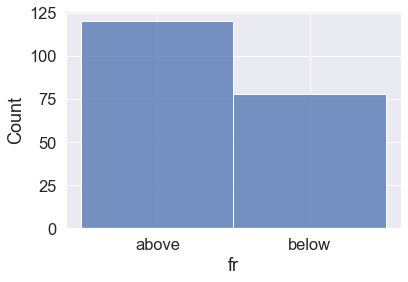

In [14]:
sns.set(font_scale = 1.5)
sns.histplot(data = data, x = 'fr');

About 75 datapoints where fertility rate is below replacement rate, and about 120 above. Not a perfect split, but not bad.
Let's see now how they're broken down by region.

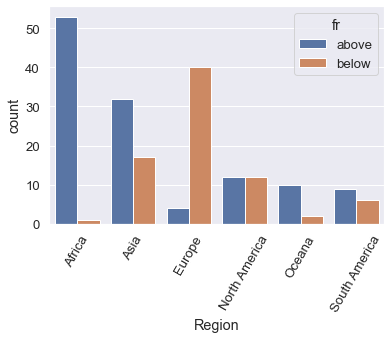

In [15]:
sns.set(font_scale = 1.2)
dataR = data[['Region','fr']].groupby(['Region','fr']).size().reset_index(name = 'count')
g = sns.barplot(data = dataR, x = 'Region', y = 'count', hue = 'fr');
plt.xticks(rotation=60);

In the above graph we can see apparent strong correlations with some regions, namely Africa, Europe, and Oceana. 

## Explore Numeric Variables
We can also use a few visualization techniques to see if we can spot any obvious trends with the continuous variables.
Because the continuous variables have different ranges, as can be seen from the summary table and earlier histograms, we will make the visualization easier by scaling the data first. It's important to note that we're scaling here with all the data, which means this scaling won't be valid (or won't be best practice) when we split the data into training and testing datasets later for machine learning. So, when we continue on to develop a model, we'll start with the original (unscaled) data, and only scale on the training set.

For visualizing the continuous data, we can use color-coded histograms such as below.

indicator_name,Region,afm,bss,cex,con,fr,lff,lrd,mri,nam,rpop,setf,ue
country_name,,,,,,,,,,,,,
Afghanistan,Asia,-0.996032,-2.421921,NaN,-0.983691,above,-2.678997,3.292250,1.474007,NaN,1.411407,NaN,0.534075
Albania,Europe,NaN,NaN,NaN,NaN,below,0.167828,-0.570519,-0.624260,0.000364,0.164760,0.311596,0.964799
Algeria,Africa,NaN,NaN,-0.544262,NaN,above,-2.530808,-0.370931,-0.150846,-0.553433,-0.509611,-0.186403,0.272624
Andorra,Europe,NaN,NaN,NaN,NaN,below,NaN,NaN,-0.925158,0.200007,-1.442820,NaN,NaN
Angola,Africa,NaN,NaN,-0.133157,NaN,above,0.949722,0.791536,1.947421,NaN,-0.169421,NaN,0.183798
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Virgin Islands (U.S.),North America,1.359149,NaN,NaN,NaN,above,0.954568,NaN,NaN,NaN,-1.696088,NaN,-0.189943
West Bank and Gaza,Asia,-0.570095,NaN,NaN,0.207633,above,-2.493885,-0.453242,-0.307313,NaN,-0.799455,0.413197,2.193284
"Yemen, Rep.",Asia,NaN,NaN,NaN,NaN,above,-2.968038,-0.001093,0.651551,-0.882427,1.058850,-1.078010,0.770387


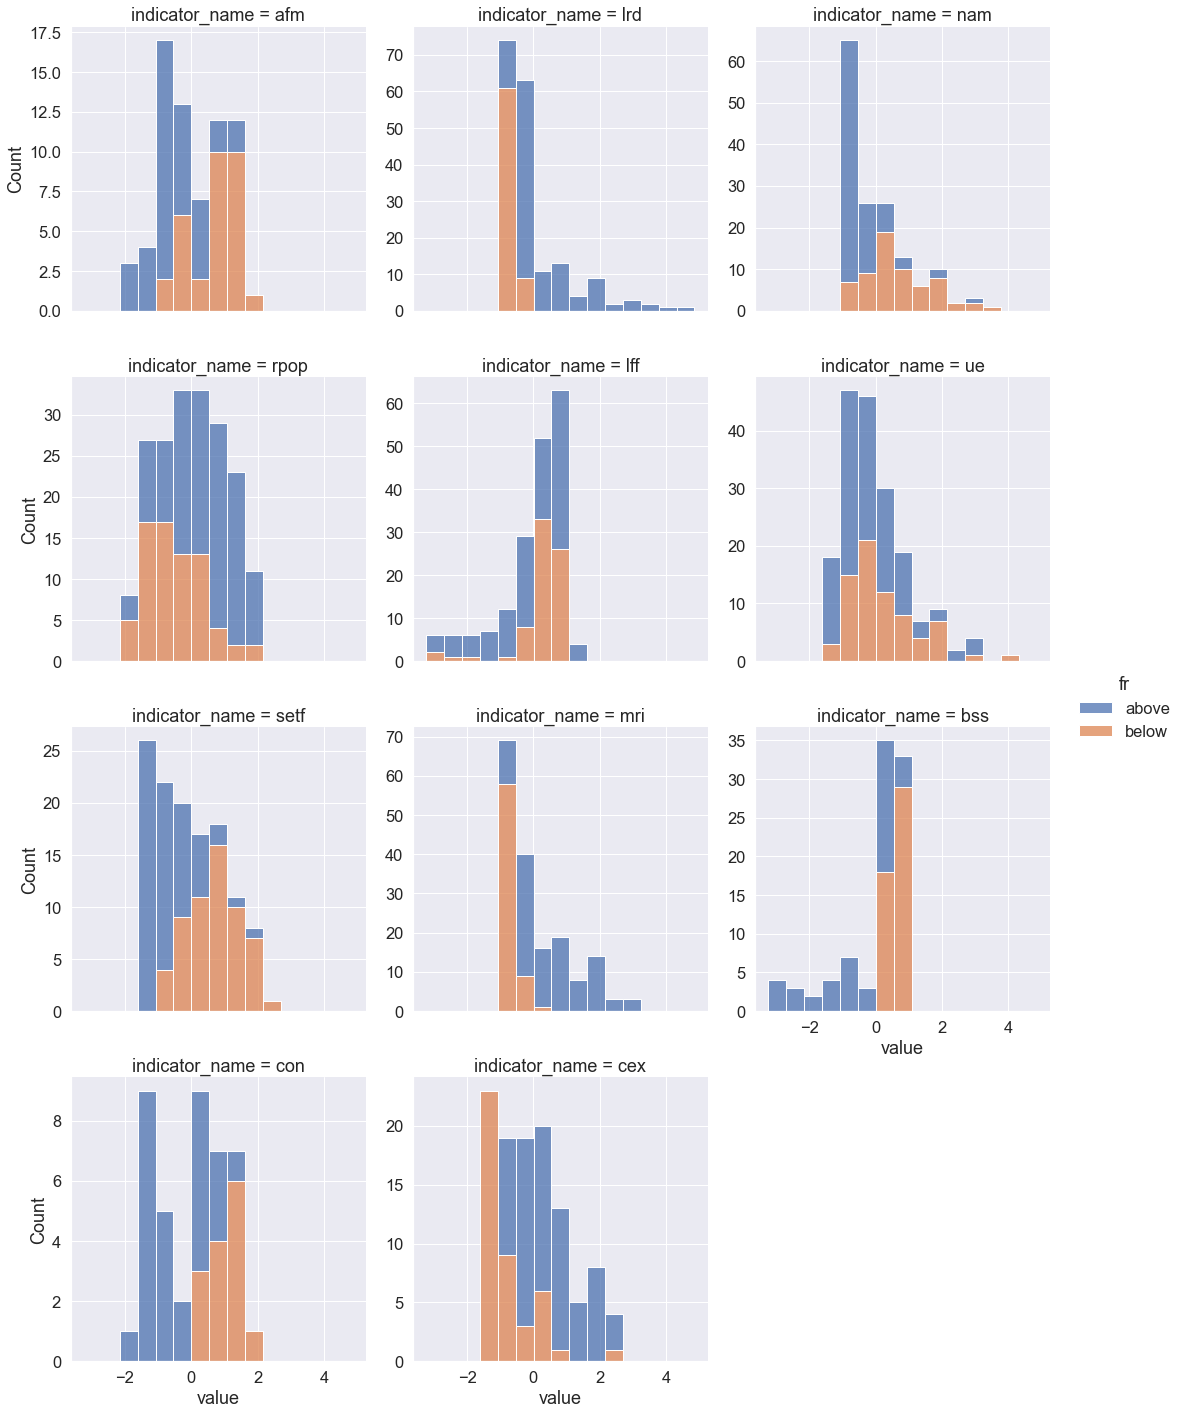

In [22]:
from sklearn.preprocessing import StandardScaler

#create a separate copy of the dataset so we preserve the original for later
data_allscaled = data.copy()

scaler_all = StandardScaler()
scaler_all.fit(data_allscaled[numeric_ind])
data_allscaled[numeric_ind] = scaler_all.transform(data_allscaled[numeric_ind])

#sns.histplot(data=data, x='afm', hue="fr", multiple="stack");
data_tidy = pd.melt(data_allscaled, id_vars = 'fr', value_vars = numeric_ind)
sns.displot(
    data_tidy, x="value", col="indicator_name", hue='fr', multiple="stack", col_wrap = 3, bins = 15,
    facet_kws=dict(sharey=False));



From the above plots it looks like several factors, such as 'con', 'afm', 'ldr', 'mri', and 'bss' could indeed have a strong correlation with the fertility rate.

### Correlation Matrix
The correlation matrix will show us how all of the continuous variables are correlated with each other, but more importantly how correlated they are with fertility rate, or 'fr'. 
To make sure 'fr' is included, we first have to convert it to numeric (0 and 1) using LabelEncoder

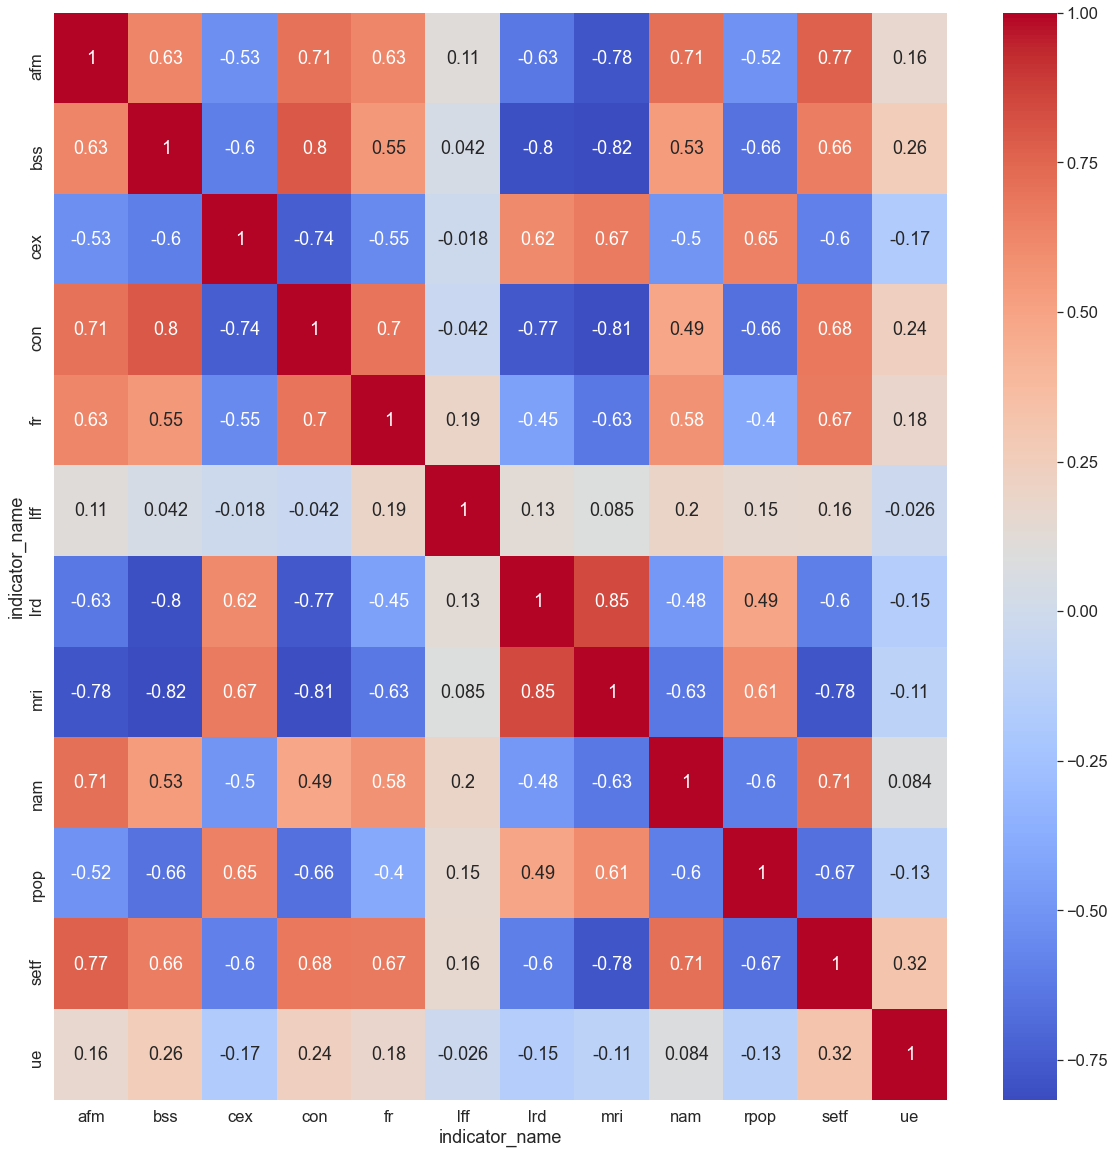

In [17]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data_allscaled.fr = le.fit_transform(data_allscaled.fr)

correlations = data_allscaled.corr()

sns.set(font_scale = 1.5)
fig, ax = plt.subplots(figsize=(20, 20))
ax = sns.heatmap(correlations, annot=True, cmap='coolwarm')

If we focus on the 'fr' variable as our fertility rate, we see that the strongest correlation it has is 0.7 with 'con', which is our abbreviation for contraceptive prevelance. Although this is only moderate-high, there are still several other variables above 0.5 (or below -0.5) which indicate moderate correlations.

## Decision Tree and Machine Learning
Since the amount of observations is high compared to the number of factors, a low-bias, high-variance method like decision trees  is appropriate.  

First, separate our X and Y

In [18]:
#'fr' is our target variable
y_raw = data.fr
X_raw = data.drop('fr',axis=1)
X_raw

indicator_name,Region,afm,bss,cex,con,lff,lrd,mri,nam,rpop,setf,ue
country_name,,,,,,,,,,,,
Afghanistan,Asia,21.5,34.3,NaN,21.8,15.479167,6.039311,64.1,NaN,76.263,NaN,11.52
Albania,Europe,NaN,NaN,NaN,NaN,42.444072,0.033876,11.8,4.0183,47.837,51.571091,14.09
Algeria,Africa,NaN,NaN,16.6,NaN,16.882805,0.344174,23.6,1.9470,32.460,35.421070,9.96
Andorra,Europe,NaN,NaN,NaN,NaN,NaN,NaN,4.3,4.7650,11.181,NaN,NaN
Angola,Africa,NaN,NaN,27.2,NaN,49.850111,2.151459,75.9,NaN,40.217,NaN,9.43
...,...,...,...,...,...,...,...,...,...,...,...,...
Virgin Islands (U.S.),North America,30.9,NaN,NaN,NaN,49.896008,NaN,NaN,NaN,5.406,NaN,7.20
West Bank and Gaza,Asia,23.2,NaN,NaN,52.5,17.232539,0.216205,19.7,NaN,25.851,54.865990,21.42
"Yemen, Rep.",Asia,NaN,NaN,NaN,NaN,12.741390,0.919161,43.6,0.7165,68.224,6.506440,12.93


### Data Encoding
Starting with the original (unscaled) data set, we'll encode the categorical variables so they can be used in the machine learning algorithms. Since our target variable ('fr' or fertility rate) has 2 levels, this can be done with LabelEncoder() as shown earlier. This will maintain one column of 0's and 1's. The 'Region' variable has 6 levels, so this will be encoded using OneHotEncoder() which will result in one column per level.

In [19]:
#to encode y we can use the same le variable we made earlier for te LabelEncoder
y =  le.fit_transform(y_raw)

Use OneHotEncoder to encode 'Region'

In [20]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

#we only want to apply OneHotEncoder to column [0], and 'pass through' the other columns. 
ct = ColumnTransformer(transformers=[('ohe', OneHotEncoder(sparse=False), [0])], remainder='passthrough')

#an array is needed for sklearn
X = np.array(ct.fit_transform(X_raw))

#np.savetxt("delete.csv", X, delimiter=",")

Split into training and test data, then scale according to training data only

In [21]:
from sklearn.model_selection import train_test_split

#split into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

#scale according to x_train. We only want to scale the columns after 6, since the first 6 are the encoded region
scaler = StandardScaler()
X_train[:, 6:] = scaler.fit_transform(X_train[:, 6:])
X_test[:, 6:] = scaler.transform(X_test[:, 6:])

#np.savetxt("delete.csv", X_train, delimiter=",")